# **Voting and Stacking**

### **Importing libraries**

In [159]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.reset_defaults()

In [160]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve

### **Testing and Training Data**

In [161]:
# loading training and testing data
train = pd.read_pickle("data/train_over_shrink.pickle")
test = pd.read_pickle("data/test.pickle")

### **Loading Models**

*Reloading random forest, xgboost and lightgbm models using joblib*

In [162]:
# loading models
rfc = joblib.load("models/rfc.pkl")
xgb = joblib.load("models/xgb.pkl")
lgb = joblib.load("models/lgb.pkl")

### **Calculating probabilities for training and testing set**

In [163]:
def predict_probability(data):
    df = pd.DataFrame()
    df["rfc"] = rfc.predict_proba(data.to_numpy()).T[1]
    df["xgb"] = xgb.predict_proba(data.to_numpy()).T[1]
    df["lgb"] = lgb.predict_proba(data.to_numpy()).T[1]
    return df

In [164]:
train_probability = predict_probability(train.iloc[:, :-1])
test_probability = predict_probability(test.iloc[:, :-1])

### **Voting Model**

*In Voting Classifier we calculate probabilities from several classifiers (RFC, Xgboost, LGBM) and we combine there predicted 
probabilities to get an average probability assosiated with the class*

In [165]:
voting_prob = test_probability.sum(axis=1)
test_pred = []
for p in voting_prob:
    if p <= 0.5:
        test_pred.append(0)
    else:
        test_pred.append(1)

In [166]:
test_actual = test["Class"].to_numpy()

In [167]:
cm = confusion_matrix(test_actual, test_pred)
print(cm)

[[70570   509]
 [   17   106]]


In [168]:
score = np.round(roc_auc_score(test_actual, test_pred), 3)
print(score)

0.927


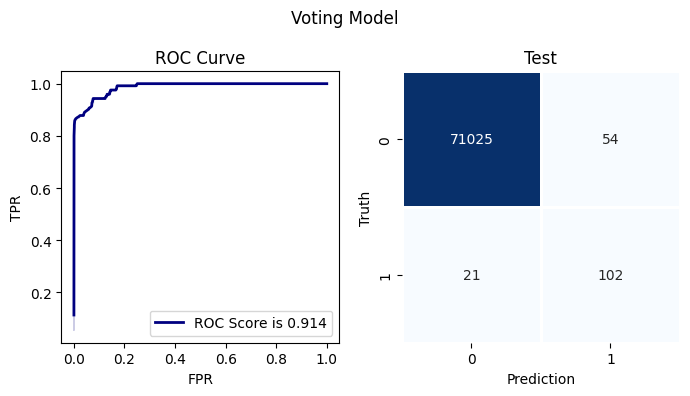

In [183]:
fpr, tpr, _ = roc_curve(test_actual, blended_prob)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,4))
fig1 = sns.lineplot(x=fpr, y=tpr, color="navy", linewidth=2.0, ax=axes[0], label = f"ROC Score is {score}")
#sns.scatterplot(x=fpr[50:80], y=tpr[50:80], color="black", ax=axes[0])
fig2 = sns.heatmap(cm, cmap="Blues", linewidths=0.9, cbar=False, annot=True, fmt="d", ax=axes[1])
fig1.set(xlabel="FPR", ylabel="TPR")
fig1.set_title("ROC Curve")
fig2.set(xlabel="Prediction", ylabel="Truth")
fig2.set_title("Test")
fig.suptitle("Voting Model")
plt.tight_layout()

*Voting Classifier improve the model by increasing the recall for class 1 to 0.86%*

In [176]:
print(classification_report(test_actual, test_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     71079
           1       0.17      0.86      0.29       123

    accuracy                           0.99     71202
   macro avg       0.59      0.93      0.64     71202
weighted avg       1.00      0.99      1.00     71202



### **Stacking Model**
*In stacking we have two levels of implementing ML models, at level 0 we calculate the predictions from several classifiers from the 
data we use to train and feed these probabilities as new features to a level 1 classifier to get final predictions.*

In [177]:
from sklearn.linear_model import LogisticRegression
# level 1 model
logit = LogisticRegression()
logit.fit(train_probability, train["Class"])

LogisticRegression()

In [178]:
test_pred = logit.predict(test_probability)

In [179]:
cm = confusion_matrix(test_actual, test_pred)
print(cm)

[[71025    54]
 [   21   102]]


In [180]:
score = np.round(roc_auc_score(test_actual, test_pred), 3)
print(score)

0.914


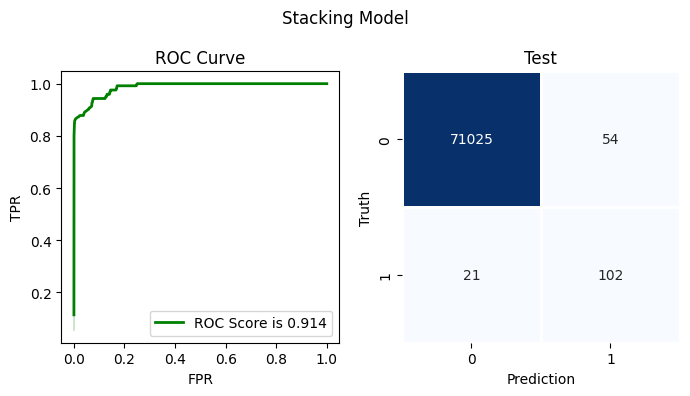

In [181]:
fpr, tpr, _ = roc_curve(test_actual, blended_prob)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,4))
fig1 = sns.lineplot(x=fpr, y=tpr, color="green", linewidth=2.0, ax=axes[0], label = f"ROC Score is {score}")
#sns.scatterplot(x=fpr[50:80], y=tpr[50:80], color="black", ax=axes[0])
fig2 = sns.heatmap(cm, cmap="Blues", linewidths=0.9, cbar=False, annot=True, fmt="d", ax=axes[1])
fig1.set(xlabel="FPR", ylabel="TPR")
fig1.set_title("ROC Curve")
fig2.set(xlabel="Prediction", ylabel="Truth")
fig2.set_title("Test")
fig.suptitle("Stacking Model")
plt.tight_layout()

*In our case stacking does not show any furthur improvement in recall rate for class 1*

In [182]:
print(classification_report(test_actual, test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.65      0.83      0.73       123

    accuracy                           1.00     71202
   macro avg       0.83      0.91      0.87     71202
weighted avg       1.00      1.00      1.00     71202

